# Spike Clustering: Full Pipeline Notebook

This notebook walks through:

1. Loading Hybrid Janelia recordings from SpikeForest.
2. Bandpass filtering.
3. Computing per-channel mean/std from 10 ms training windows.
4. Normalizing validation traces.
5. Segmenting validation data into 2 ms windows.
6. Extracting latent embeddings with a pretrained CNN.
7. Performing K‑means clustering.
8. Evaluating clusters against ground truth (sensitivity & specificity).


Checkpoint epoch 10 is multilabel, checkpoint epoch 30 is regression model

## 1. Imports and Device Setup
We import necessary packages, set the device, and configure inline plotting.

In [221]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from spikeinterface.preprocessing import bandpass_filter
import spikeforest as sf

%matplotlib inline

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [222]:
import matplotlib.pyplot as plt
import re
import os

os.makedirs('figures', exist_ok=True)

def save_fig(fig=None, dpi=1000, formats=('pdf', 'png')):

    if fig is None:
        fig = plt.gcf()
    
    axes = fig.get_axes()
    if not axes:
        title = None
    else:
        # Try to get title from main axes
        title = axes[0].get_title()
        
        # If no title in first axes, check others
        if not title and len(axes) > 1:
            for ax in axes:
                if ax.get_title():
                    title = ax.get_title()
                    break
    
    # Create filename from title
    if title:
        # Sanitize title for filename
        filename = re.sub(r'[^\w\s-]', '', title)
        filename = re.sub(r'[\s-]+', '_', filename).strip('_')
        filename = filename[:100]  # Limit length
    else:
        # Default name if no title
        import time
        filename = f"figure_{int(time.time())}"
    
    # Store titles and then remove them
    titles = {}
    for ax in axes:
        if ax.get_title():
            titles[ax] = ax.get_title()
            ax.set_title("")
    
    # Save figure without titles
    for fmt in formats:
        filepath = f'figures/{filename}.{fmt}'
        fig.savefig(filepath, dpi=dpi if fmt != 'pdf' else None, bbox_inches='tight')
        print(f"Saved: {filepath}")
    
    # Restore titles
    for ax, title in titles.items():
        ax.set_title(title)
    
    return fig

In [223]:
model_typp =  "regression" # or multi-label classification or "regression"

## 2. Load Hybrid Janelia Catalog and Select Recordings

We load the SpikeForest JSON catalog, then find the specified training and validation recordings.

In [224]:
# Load SpikeForest catalog
uri = "sha1://43298d72b2d0860ae45fc9b0864137a976cb76e8?hybrid-janelia-spikeforest-recordings.json"
all_recordings = sf.load_spikeforest_recordings(uri)

#Validation recording
val_name = "rec_64c_600s_12"
val_rec_obj = next(R for R in all_recordings if R.recording_name == val_name)
recording_val = val_rec_obj.get_recording_extractor()
sorting_val_gt = val_rec_obj.get_sorting_true_extractor()

# Training recording (for mean/std)
train_name = "rec_64c_1200s_11"
train_rec_obj = next(R for R in all_recordings if R.recording_name == train_name)
recording_train = train_rec_obj.get_recording_extractor()
sorting_train_gt = train_rec_obj.get_sorting_true_extractor()

# Bandpass filter both (300-6000 Hz)
recording_train_f = bandpass_filter(recording_train, freq_min=300, freq_max=6000, dtype="float32")
recording_val_f = bandpass_filter(recording_val, freq_min=300, freq_max=6000, dtype="float32")

fs = recording_train_f.get_sampling_frequency()
print("Sampling frequency:", fs)

Sampling frequency: 30000.0


## 3. Compute or Load Mean/Std from Training Data (10 ms windows)

We define a `SpikeCountDataset` to yield 10 ms windows from the training recording, then compute per-channel mean and standard deviation across all windows. If saved files exist, we load them instead of recomputing.

In [225]:
# Define SpikeCountDataset for 10 ms windows
class SpikeCountDataset(Dataset):
    def __init__(self, recording_extractor, sorting_true, win_samples):
        self.rec = recording_extractor
        self.sorting = sorting_true
        self.win_samples = win_samples
        self.n_chan = self.rec.get_num_channels()
        total_samples = int(self.rec.get_num_frames())
        self.starts = list(range(0, total_samples - win_samples + 1, win_samples))

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx):
        start = self.starts[idx]
        end = start + self.win_samples
        snippet = self.rec.get_traces(start_frame=start, end_frame=end).astype(np.float32)
        X = torch.from_numpy(snippet)  # shape (n_chan, win_samples)
        return X, 0  # dummy label

mean_path = "mean.npy"
std_path = "std.npy"
WIN_SAMPLES = int(0.010 * fs)  # 10 ms windows

if os.path.exists(mean_path) and os.path.exists(std_path):
    mean = np.load(mean_path)
    std = np.load(std_path)
    print("Loaded mean/std from disk. shapes:", mean.shape, std.shape)
else:
    train_dataset_nonnorm = SpikeCountDataset(recording_train_f, sorting_train_gt, WIN_SAMPLES)
    train_loader_nonnorm = DataLoader(train_dataset_nonnorm, batch_size=32, shuffle=True, drop_last=True)

    sum_ = torch.zeros(train_dataset_nonnorm.n_chan)
    sum_sq = torch.zeros(train_dataset_nonnorm.n_chan)
    count_ = 0

    with torch.no_grad():
        for X_batch, _ in train_loader_nonnorm:
            B, C, W = X_batch.shape
            sum_ += X_batch.sum(dim=(0, 2))
            sum_sq += (X_batch ** 2).sum(dim=(0, 2))
            count_ += B * W

    mean = (sum_ / count_).numpy()
    var = (sum_sq / count_) - (sum_ / count_)**2
    std = torch.sqrt(torch.from_numpy(var)).numpy()

    np.save(mean_path, mean)
    np.save(std_path, std)
    print("Computed & saved mean/std. shapes:", mean.shape, std.shape)

Loaded mean/std from disk. shapes: (64,) (64,)


## 4. Normalize Validation Traces

We load the full validation trace, normalize each channel by the computed mean/std, and then transpose to `(samples, channels)` for windowing.

In [226]:
# Truncate validation samples to speed up testing
max_val_samples = int(18000001*0.1)  # adjust this as needed
traces_val = recording_val_f.get_traces(start_frame=0, end_frame=max_val_samples).astype(np.float32)
print("traces_val.shape before normalize:", traces_val.shape)

# Normalize
print("mean.shape:", mean.shape, "std.shape:", std.shape)
traces_val_norm = (traces_val - mean[None, :]) / std[None, :]
print("traces_val_norm.shape after normalize:", traces_val_norm.shape)
traces_for_windowing = traces_val_norm
print("traces_for_windowing.shape:", traces_for_windowing.shape)

traces_val.shape before normalize: (1800000, 64)
mean.shape: (64,) std.shape: (64,)
traces_val_norm.shape after normalize: (1800000, 64)
traces_for_windowing.shape: (1800000, 64)


## 5. Segment Validation Data into 2 ms Windows

Now we slice the normalized validation trace (shape `(n_samples, n_channels)`) into non-overlapping 2 ms windows (60 samples each at 30 kHz).

In [227]:
sampling_rate = fs
window_ms = 2
window_samples = int(window_ms * sampling_rate / 1000)  # 60 samples
stride = window_samples

windows = []
window_starts = []
num_samples = traces_for_windowing.shape[0]

for start in tqdm(range(0, num_samples - window_samples + 1, stride)):
    seg = traces_for_windowing[start : start + window_samples, :]  # (60, 64)
    windows.append(seg)
    window_starts.append(start)

windows = np.stack(windows, axis=0)  # (n_windows, 60, 64)
windows_tensor = torch.from_numpy(windows).float().permute(0, 2, 1)  # (n_windows, 64, 60)
print("Number of windows:", windows_tensor.shape[0])
print("windows_tensor.shape:", windows_tensor.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 417257.88it/s]


Number of windows: 30000
windows_tensor.shape: torch.Size([30000, 64, 60])


## 6. Assign Ground Truth Labels to Each Window

For each 2 ms window, we check if exactly one neuron spiked. If so, that neuron's ID is the label; otherwise label = -1.

In [228]:
# Build ground truth spike times dict: neuron_id → array of spike sample indices
ground_truth = {
    u: sorting_val_gt.get_unit_spike_train(u, segment_index=0)
    for u in sorting_val_gt.get_unit_ids()
}

n_windows = windows_tensor.shape[0]
gt_labels = -1 * np.ones(n_windows, dtype=int)

for i, start in tqdm(enumerate(window_starts)):
    end = start + window_samples
    labels_in_window = []
    for neuron_id, spike_times in ground_truth.items():
        if np.any((spike_times >= start) & (spike_times < end)):
            labels_in_window.append(neuron_id)
    if len(labels_in_window) == 1:
        gt_labels[i] = labels_in_window[0]
    else:
        gt_labels[i] = -1

print("Assigned GT labels for all windows. Sample of labels:", gt_labels[:20])

30000it [00:22, 1329.54it/s]

Assigned GT labels for all windows. Sample of labels: [-1 -1 44 -1 -1 -1  9 50 21 35 71 50 -1 12 -1 51 -1 -1 -1 -1]


In [229]:
valid_mask = (gt_labels != -1)

# Apply mask to both windows and labels:
windows_tensor_filtered = windows_tensor[valid_mask]  # Shape: (n_valid, 64, 60)
gt_labels_filtered    = gt_labels[valid_mask]         # Shape: (n_valid,)

print("Original number of windows:", windows_tensor.shape[0])
print("Filtered number of windows:", windows_tensor_filtered.shape[0])

Original number of windows: 30000
Filtered number of windows: 10864


## 7. Extract Latent Embeddings Using CNN

We load a pretrained CNN (e.g., `MySpikeCNN`), wrap it to grab penultimate-layer outputs, and run inference over all windows to get embedding vectors.

In [230]:
class BasicBlock1D(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm1d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.down  = (
            nn.Sequential(
                nn.Conv1d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes),
            )
            if (stride != 1 or in_planes != planes)
            else nn.Identity()
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.down(x)
        return self.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, layers, in_ch, out_dim=1):
        super().__init__()
        self.in_planes = 64
        self.conv1     = nn.Conv1d(in_ch, 64,
                                   kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1       = nn.BatchNorm1d(64)
        self.relu      = nn.ReLU(inplace=True)
        self.maxpool   = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1    = self._make_layer(layers[0],  64)
        self.layer2    = self._make_layer(layers[1], 128, stride=2)
        self.layer3    = self._make_layer(layers[2], 256, stride=2)
        self.layer4    = self._make_layer(layers[3], 512, stride=2)
        self.avgpool   = nn.AdaptiveAvgPool1d(1)
        self.fc        = nn.Linear(512, out_dim)

    def _make_layer(self, blocks, planes, stride=1):
        layers = [BasicBlock1D(self.in_planes, planes, stride)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)
        return self.fc(x)

In [231]:
# 7. Extract Latent Embeddings Using ResNet1D
#We load a pretrained ResNet1D, wrap it to grab the 512‐dim features 
# (the output of avgpool before the final `fc`), and run inference over all windows.

import torch.nn as nn

# 7a. Define the ResNet1D model exactly as in class definition
model = ResNet1D(layers=[2, 2, 2, 2], in_ch=64, out_dim=74)
checkpoint = torch.load("./checkpoints/checkpoint_epoch_10.pth", map_location=device)

# Get state dict from checkpoint and modify
state_dict = checkpoint["model_state_dict"]

# Remove the mismatched parameters
if 'fc.weight' in state_dict:
    del state_dict['fc.weight']
if 'fc.bias' in state_dict:
    del state_dict['fc.bias']

# Load the modified state dict
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)
# 7b. Wrap the ResNet1D so that we return the embedding just before the final fc layer.
class Embedder(nn.Module):
    def __init__(self, resnet_model):
        super().__init__()
        # Copy everything except the final `fc`:
        self.conv1   = resnet_model.conv1
        self.bn1     = resnet_model.bn1
        self.relu    = resnet_model.relu
        self.maxpool = resnet_model.maxpool
        self.layer1  = resnet_model.layer1
        self.layer2  = resnet_model.layer2
        self.layer3  = resnet_model.layer3
        self.layer4  = resnet_model.layer4
        self.avgpool = resnet_model.avgpool

    def forward(self, x):
        # x: (batch, 64, 60)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # AdaptiveAvgPool1d(1) → (batch, 512, 1)
        x = self.avgpool(x)            # → (batch, 512, 1)
        x = x.squeeze(-1)              # → (batch, 512)
        return x

embedder = Embedder(model).to(device)
embedder.eval()

batch_size = 256
loader = DataLoader(windows_tensor_filtered, batch_size=batch_size, shuffle=False)

all_embeddings = []
with torch.no_grad():
    for batch in tqdm(loader):
        batch = batch.to(device)        # (B, 64, 60)
        z = embedder(batch)             # (B, 512)
        all_embeddings.append(z.cpu().numpy())

all_embeddings = np.concatenate(all_embeddings, axis=0)  # → (n_windows, 512)
print("Embeddings shape:", all_embeddings.shape)  # should be (n_windows, 512)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:05<00:00,  8.57it/s]

Embeddings shape: (10864, 512)


## 8. K‑Means Clustering in Latent Space

Cluster the embeddings into a specified number of clusters (e.g., 10).

In [232]:
num_clusters = 74 #manual for now
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_ids = kmeans.fit_predict(all_embeddings)
print("Cluster IDs shape:", cluster_ids.shape)

/Users/ryan/opt/anaconda3/envs/spike_sorting/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster IDs shape: (10864,)


In [233]:
!pip install hdbscan

In [234]:

import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
hdbscan_labels = clusterer.fit_predict(all_embeddings)
print("HDBSCAN Labels shape:", hdbscan_labels.shape)
print("Num unique clusters (excluding noise):", len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0))

HDBSCAN Labels shape: (10864,)
Num unique clusters (excluding noise): 2


## 9. Evaluate Clusters (Sensitivity & Specificity)

For each cluster, identify the predominant true neuron and compute:

- TP: True Positives
- FP: False Positives
- FN: False Negatives
- TN: True Negatives

Then compute sensitivity = TP/(TP+FN) and specificity = TN/(TN+FP).

In [235]:
results = []
for c in range(num_clusters):
    idx_c = np.where(cluster_ids == c)[0]
    labels_c = gt_labels_filtered[idx_c]
    valid = labels_c != -1
    if valid.sum() == 0:
        continue
    target = np.bincount(labels_c[valid]).argmax()
    TP = np.sum((cluster_ids == c) & (gt_labels_filtered == target))
    FP = np.sum((cluster_ids == c) & (gt_labels_filtered != target))# & (gt_labels_filtered != -1))
    FN = np.sum((cluster_ids != c) & (gt_labels_filtered == target))
    TN = np.sum((cluster_ids != c) & ((gt_labels_filtered != target)))# | (gt_labels_filtered == -1)))
    sens = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    spec = TN / (TN + FP) if (TN + FP) > 0 else np.nan
    results.append({
        "cluster": c,
        "target_neuron": int(target),
        "sensitivity": sens,
        "specificity": spec,
        "cluster_size": len(idx_c)
    })

results_df = pd.DataFrame(results)
results_df

,cluster,target_neuron,sensitivity,specificity,cluster_size
0,0,11,0.866667,1.000000,91
1,1,18,0.853061,0.999906,210
2,2,30,0.913043,0.999907,148
3,3,33,0.935484,1.000000,29
4,4,1,0.822034,1.000000,194
...,...,...,...,...,...
69,69,25,0.807692,0.997404,91
70,70,57,0.895833,1.000000,43
71,71,29,0.904762,1.000000,38
72,72,66,0.680000,0.999813,104


In [236]:

results_hdbscan = []
unique_clusters = set(hdbscan_labels)
if -1 in unique_clusters:
    unique_clusters.remove(-1)  # ignore noise points

for c in unique_clusters:
    idx_c = np.where(hdbscan_labels == c)[0]
    labels_c = gt_labels_filtered[idx_c]
    valid = labels_c != -1
    if valid.sum() == 0:
        continue
    target = np.bincount(labels_c[valid]).argmax()
    TP = np.sum((hdbscan_labels == c) & (gt_labels_filtered == target))
    FP = np.sum((hdbscan_labels == c) & (gt_labels_filtered != target))
    FN = np.sum((hdbscan_labels != c) & (gt_labels_filtered == target))
    TN = np.sum((hdbscan_labels != c) & (gt_labels_filtered != target))
    sens = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    spec = TN / (TN + FP) if (TN + FP) > 0 else np.nan
    results_hdbscan.append({
        "cluster": int(c),
        "target_neuron": int(target),
        "sensitivity": sens,
        "specificity": spec,
        "cluster_size": len(idx_c)
    })

results_hdbscan_df = pd.DataFrame(results_hdbscan)
results_hdbscan_df


,cluster,target_neuron,sensitivity,specificity,cluster_size
0,0,68,0.996226,0.014813,10706
1,1,33,0.935484,1.000000,29


**Interpretation:** Each row shows:

- `cluster`: cluster index.
- `target_neuron`: neuron ID that is most common in this cluster.
- `sensitivity`: fraction of that neuron's true windows correctly assigned.
- `specificity`: fraction of other windows correctly not assigned.
- `cluster_size`: number of windows in this cluster.

In [238]:


import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Define the ResNet1D model
model_full = ResNet1D(layers=[2, 2, 2, 2], in_ch=64, out_dim=74)
checkpoint = torch.load("./checkpoints/checkpoint_epoch_30.pth", map_location=device)

# Get state dict from checkpoint and modify it
state_dict = checkpoint["model_state_dict"]

# Remove the mismatched parameters
if 'fc.weight' in state_dict:
    del state_dict['fc.weight']
if 'fc.bias' in state_dict:
    del state_dict['fc.bias']

# Load the modified state dict
model_full.load_state_dict(state_dict, strict=False)
model_full.eval()
model_full.to(device)

# Build ground‐truth count for each window
# ground_truth was the dict: neuron_id -> spike‐time array (in sample indices).
# window_starts is the list of start‐indices (in samples) for each 2 ms window.
#
# For each window i, we want true_count[i] = number of distinct neurons that spiked in [start, start+window_samples)
n_windows = len(window_starts)
true_count = np.zeros(n_windows, dtype=int)

for i, start in tqdm(enumerate(window_starts)):
    end = start + window_samples
    # Count how many neurons have at least one spike in this interval:
    cnt = 0
    for neuron_id, spike_times in ground_truth.items():
        # `spike_times` is a NumPy array of sample‐indices for that unit
        if np.any((spike_times >= start) & (spike_times < end)):
            cnt += 1
    true_count[i] = cnt

print(f"Example true counts (first 20 windows): {true_count[:20]}")

# Run the CNN (with its final FC) over all windows to get predicted count
# We reuse windows_tensor, which is shape (n_windows, 64, 60).
batch_size = 256
eval_loader = DataLoader(windows_tensor, batch_size=batch_size, shuffle=False)

preds = []
with torch.no_grad():
    for batch in tqdm(eval_loader):
        batch = batch.to(device)                  # (B, 64, 60)
        out = model_full(batch).squeeze(-1)       # (B,)  — raw real‐valued outputs
        preds.append(out.cpu().numpy())

preds = np.concatenate(preds, axis=0)             # shape: (n_windows,)
print(f"Example raw predictions (first 20): {preds[:20]}")

# Compute MSE between raw prediction and true_count
mse = np.mean((preds - true_count.astype(float))**2)
print(f"MSE (predicted count vs. true count): {mse:.4f}")

# Compute exact‐match accuracy if you round to nearest integer
pred_int = np.rint(preds).astype(int)
exact_match = np.mean(pred_int == true_count)
print(f"Exact‐match accuracy (round(pred)==true): {exact_match*100:.2f}%")

# Show a small confusion table for 0 vs 1+ counts
# (Most windows will have 0 or 1 spikes in 2 ms, possibly >1 if bursts.)
true_binary = (true_count > 0).astype(int)
pred_binary = (pred_int > 0).astype(int)
tp = np.sum((pred_binary == 1) & (true_binary == 1))
tn = np.sum((pred_binary == 0) & (true_binary == 0))
fp = np.sum((pred_binary == 1) & (true_binary == 0))
fn = np.sum((pred_binary == 0) & (true_binary == 1))

print("\nBinary spike/no‐spike confusion (2 ms window):")
print(f"  TP (pred=1, true=1): {tp}")
print(f"  TN (pred=0, true=0): {tn}")
print(f"  FP (pred=1, true=0): {fp}")
print(f"  FN (pred=0, true=1): {fn}")

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

print(f"Sensitivity (TP / (TP + FN)) = {sensitivity:.4f}")
print(f"Specificity (TN / (TN + FP)) = {specificity:.4f}")

30000it [00:21, 1373.56it/s]


Example true counts (first 20 windows): [0 0 1 2 4 0 1 1 1 1 1 1 0 1 2 1 0 0 0 0]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:13<00:00,  8.90it/s]

Example raw predictions (first 20): [[-2.0282519e-01 -7.5115353e-02  5.4506528e-01 ... -1.9958195e-01
  -2.2450805e-01  3.9083943e-01]
 [-7.3112510e-03  4.0392745e-03 -3.6660913e-02 ... -4.3674327e-02
  -3.6877207e-04 -4.8794746e-02]
 [-4.1664469e-01  1.5299210e-01  7.1454912e-02 ... -1.6909620e-01
  -2.9424913e-02  1.4626670e-01]
 ...
 [-5.8346298e-03  1.1290880e-02 -3.2046653e-02 ... -4.7700655e-02
   6.3528791e-03 -4.8804559e-02]
 [-1.1384104e-02  9.5445830e-03 -4.0674377e-02 ... -4.4486422e-02
   6.6291355e-03 -5.2797846e-02]
 [-1.2631360e-02  5.9569869e-03 -3.2065935e-02 ... -4.1136116e-02
   3.7806202e-03 -5.1126607e-02]]


ValueError: operands could not be broadcast together with shapes (30000,74) (30000,) 

## 10. (Optional) Visualize Embedding Clusters in 2D

You can project to 2D (e.g., PCA) and plot colored by cluster ID for qualitative evaluation.


Saved: figures/PCA_of_Latent_Embeddings_colored_by_cluster.pdf
Saved: figures/PCA_of_Latent_Embeddings_colored_by_cluster.png


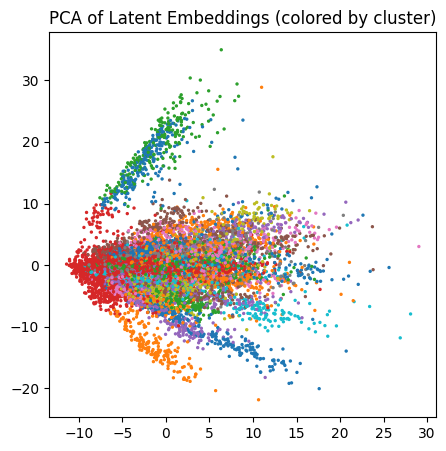

In [239]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(all_embeddings)
plt.figure(figsize=(5,5))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=cluster_ids, s=2, cmap='tab10')
plt.title('PCA of Latent Embeddings (colored by cluster)')
save_fig()
plt.show()

In [240]:
#some more quantifying/plotting of the clusters:

from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score


v_score = v_measure_score(gt_labels_filtered, cluster_ids)
homogeneity = homogeneity_score(gt_labels_filtered, cluster_ids)
completeness = completeness_score(gt_labels_filtered, cluster_ids)

print(f"V-measure: {v_score:.4f}")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")

V-measure: 0.8528
Homogeneity: 0.8294
Completeness: 0.8775


In [241]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(gt_labels_filtered, cluster_ids)
print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 0.4100


In [242]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(all_embeddings, cluster_ids, sample_size=10000)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.4347


In [243]:

#Davies-bouldin; lower = better here
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(all_embeddings, cluster_ids)
print(f"Davies-Bouldin Index: {db_score:.4f}")

Davies-Bouldin Index: 0.9284


In [244]:
# Create a dataframe with per-cluster quality metrics
cluster_quality = pd.DataFrame()
cluster_quality['cluster_id'] = np.unique(cluster_ids)
cluster_quality['size'] = [np.sum(cluster_ids == c) for c in cluster_quality['cluster_id']]
cluster_quality['purity'] = [
    np.max(np.bincount(gt_labels_filtered[cluster_ids == c], minlength=len(np.unique(gt_labels_filtered)))) / 
    np.sum(cluster_ids == c) 
    for c in cluster_quality['cluster_id']
]

# Calculate intra-cluster distance (cohesion)
from sklearn.metrics import pairwise_distances_argmin_min
cluster_centers = np.array([np.mean(all_embeddings[cluster_ids == c], axis=0) for c in np.unique(cluster_ids)])
cluster_quality['cohesion'] = [
    np.mean(pairwise_distances_argmin_min(all_embeddings[cluster_ids == c], np.array([cluster_centers[i]]))[1])
    for i, c in enumerate(cluster_quality['cluster_id'])
]

# Sort by purity to find best clusters
best_clusters = cluster_quality.sort_values('purity', ascending=False).head(10)
print("Top 10 clusters by purity:")
print(best_clusters)

Top 10 clusters by purity:
    cluster_id  size  purity   cohesion
0            0    91     1.0  13.278725
51          51    99     1.0  13.014271
34          34    60     1.0  10.004603
35          35   153     1.0   9.836364
36          36    50     1.0  15.171272
38          38    92     1.0  12.418094
40          40   104     1.0  13.078739
41          41   136     1.0  11.859765
44          44   109     1.0  12.921787
45          45   178     1.0  11.377824


Saved: figures/PCA_of_Top_10_Clusters_by_Purity.pdf
Saved: figures/PCA_of_Top_10_Clusters_by_Purity.png


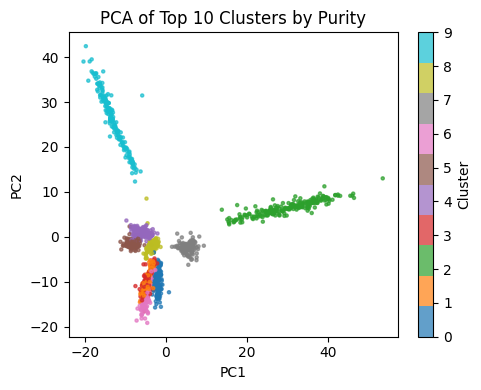

In [245]:
# Select top 10 clusters by purity that have at least 100 points
top_clusters = cluster_quality[cluster_quality['size'] > 100].sort_values('purity', ascending=False).head(10)['cluster_id'].values

# Create a mask for points in these clusters
mask = np.isin(cluster_ids, top_clusters)

# PCA projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_2d_top = pca.fit_transform(all_embeddings[mask])

# Remap cluster IDs for the plot (to consecutive integers starting from 0)
cluster_map = {c: i for i, c in enumerate(top_clusters)}
plot_labels = np.array([cluster_map[c] for c in cluster_ids[mask]])

plt.figure(figsize=(5, 4))
scatter = plt.scatter(emb_2d_top[:, 0], emb_2d_top[:, 1], c=plot_labels, cmap='tab10', s=5, alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('PCA of Top 10 Clusters by Purity')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
save_fig()
plt.show()

In [246]:
!pip install seaborn

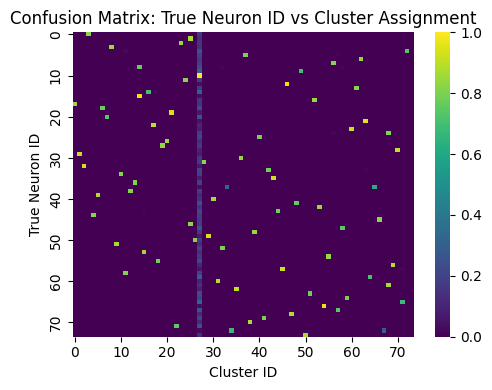

In [247]:
# Create a confusion matrix between ground truth and cluster assignments
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get unique neuron IDs and cluster IDs
unique_neurons = np.unique(gt_labels_filtered)
unique_clusters = np.unique(cluster_ids)

# Create confusion matrix
conf_matrix = confusion_matrix(gt_labels_filtered, cluster_ids, 
                               labels=unique_neurons, 
                               normalize='true')  # normalize by row (true label)

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, cmap='viridis', 
            xticklabels=10 if len(unique_clusters) > 10 else 1,  # show every 10th label if many
            yticklabels=10 if len(unique_neurons) > 10 else 1)
plt.xlabel('Cluster ID')
plt.ylabel('True Neuron ID')
plt.title('Confusion Matrix: True Neuron ID vs Cluster Assignment')
plt.tight_layout()
plt.show()

Saved: figures/Original_Confusion_Matrix.pdf
Saved: figures/Original_Confusion_Matrix.png


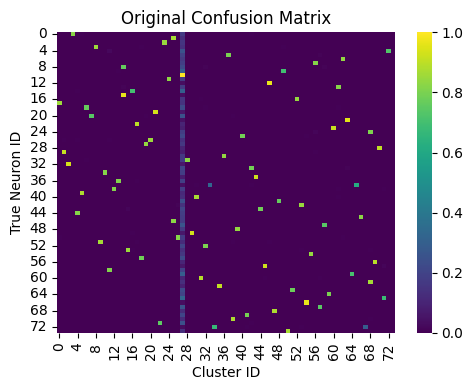

Saved: figures/Reordered_Confusion_Matrix_Hungarian_Algorithm.pdf
Saved: figures/Reordered_Confusion_Matrix_Hungarian_Algorithm.png


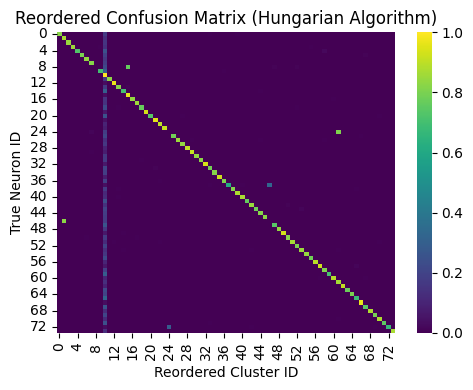

Sum of diagonal elements (original): 0.1672
Sum of diagonal elements (reordered): 59.2057
Improvement: 59.0385


In [249]:
# Create a properly reordered confusion matrix between ground truth and cluster assignments
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get unique labels
unique_neurons = np.unique(gt_labels_filtered)
unique_clusters = np.unique(cluster_ids)

# Create initial confusion matrix (rows=true neurons, columns=clusters)
conf_matrix = confusion_matrix(gt_labels_filtered, cluster_ids, 
                              labels=unique_neurons, 
                              normalize='true')  # normalize by row

# Find optimal mapping of clusters to neurons using the Hungarian algorithm
from scipy.optimize import linear_sum_assignment

# Negate the matrix because the algorithm minimizes cost
# (we want to maximize the diagonal elements)
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

# Reorder the columns of the confusion matrix
conf_matrix_reordered = conf_matrix[:, col_ind]

# Plot the original confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, cmap='viridis')
plt.xlabel('Cluster ID')
plt.ylabel('True Neuron ID')
plt.title('Original Confusion Matrix')
plt.tight_layout()
save_fig()
plt.show()

# Plot the reordered confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_reordered, cmap='viridis')
plt.xlabel('Reordered Cluster ID')
plt.ylabel('True Neuron ID')
plt.title('Reordered Confusion Matrix (Hungarian Algorithm)')
plt.tight_layout()
save_fig()
plt.show()

# Compute diagonal sum (matching accuracy)
diagonal_sum_original = np.trace(conf_matrix)
diagonal_sum_reordered = np.trace(conf_matrix_reordered)

print(f"Sum of diagonal elements (original): {diagonal_sum_original:.4f}")
print(f"Sum of diagonal elements (reordered): {diagonal_sum_reordered:.4f}")
print(f"Improvement: {diagonal_sum_reordered - diagonal_sum_original:.4f}")

/Users/ryan/opt/anaconda3/envs/spike_sorting/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/ryan/opt/anaconda3/envs/spike_sorting/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Saved: figures/UMAP_Projection_of_Cluster_Embeddings_Subsampled.pdf
Saved: figures/UMAP_Projection_of_Cluster_Embeddings_Subsampled.png


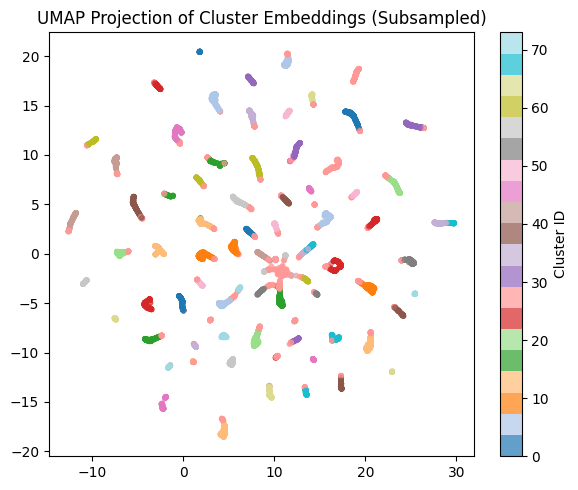

Saved: figures/UMAP_Projection_of_Embeddings_Colored_by_True_Neuron_ID.pdf
Saved: figures/UMAP_Projection_of_Embeddings_Colored_by_True_Neuron_ID.png


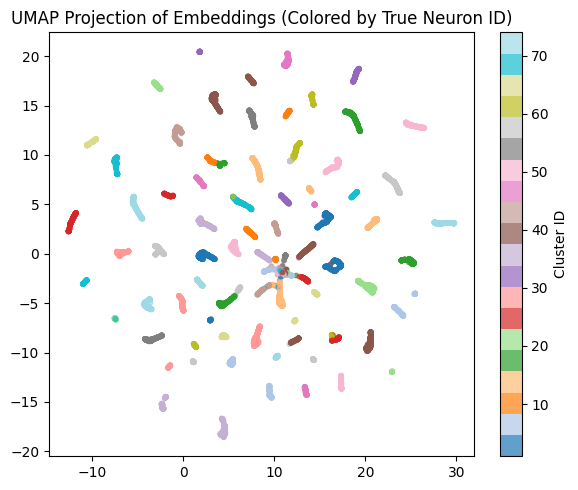

In [250]:
# # UMAP; this takes a a few seconds to run, on truncated
# from umap.umap_ import UMAP
# # Subsample if dataset is very large
# n_samples = min(10000, len(all_embeddings))
# indices = np.random.choice(len(all_embeddings), n_samples, replace=False)

# # Run UMAP
# # Use the imported umap module to create the UMAP model
# umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
# embeddings_umap = umap_model.fit_transform(all_embeddings[indices])

# plt.figure(figsize=(6, 5))
# scatter = plt.scatter(
#     embeddings_umap[:, 0], 
#     embeddings_umap[:, 1], 
#     c=cluster_ids[indices], 
#     cmap='tab20', 
#     s=10, 
#     alpha=0.7
# )
# plt.colorbar(scatter, label='Cluster ID')
# plt.title('UMAP Projection of Cluster Embeddings (Subsampled)')
# plt.tight_layout()
# save_fig()
# plt.show()

# plt.figure(figsize=(6, 5))
# scatter = plt.scatter(
#     embeddings_umap[:, 0], 
#     embeddings_umap[:, 1], 
#     c=gt_labels_filtered[indices], 
#     cmap='tab20', 
#     s=10, 
#     alpha=0.7
# )
# plt.colorbar(scatter, label='Cluster ID')
# plt.title('UMAP Projection of Embeddings (Colored by True Neuron ID)')
# plt.tight_layout()
# save_fig()
# plt.show()

In [251]:
# UMAP visualization with distinct colors for all clusters
from umap.umap_ import UMAP
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import time

print("Computing UMAP projection...")
start_time = time.time()

# Subsample if dataset is very large
n_samples = min(10000, len(all_embeddings))
indices = np.random.choice(len(all_embeddings), n_samples, replace=False)

# Run UMAP
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embeddings_umap = umap_model.fit_transform(all_embeddings[indices])

print(f"UMAP completed in {time.time() - start_time:.2f} seconds")


Computing UMAP projection...


/Users/ryan/opt/anaconda3/envs/spike_sorting/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/ryan/opt/anaconda3/envs/spike_sorting/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UMAP completed in 16.39 seconds


Saved: figures/UMAP_Projection_of_74_Clusters.pdf
Saved: figures/UMAP_Projection_of_74_Clusters.png


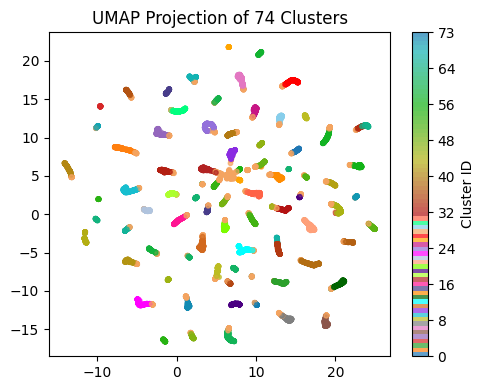

Saved: figures/UMAP_Projection_Colored_by_True_Neuron_ID.pdf
Saved: figures/UMAP_Projection_Colored_by_True_Neuron_ID.png


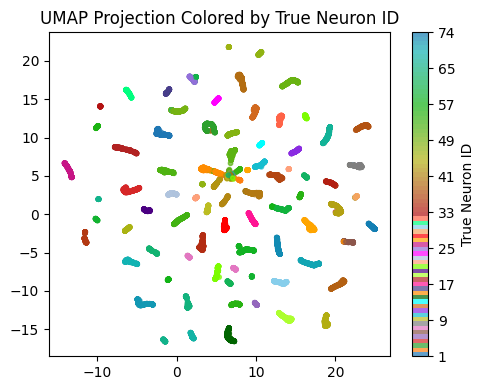

In [252]:
#distinct non-white colors plots
# Generate distinct colors function
def generate_distinct_colors(n):
    """Generate n visually distinct colors, avoiding white or very light colors"""
    # Start with some distinct base colormaps
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    base_colors.extend(list(mcolors.CSS4_COLORS.values())[::5])  # Take every 5th CSS color
    
    # Filter out very light colors from the base colors
    filtered_base_colors = []
    for color in base_colors:
        rgb = mcolors.to_rgb(color)
        # Skip colors that are too light (high average RGB value)
        if sum(rgb)/3 < 0.8:  # This threshold avoids very light colors
            filtered_base_colors.append(color)
    
    base_colors = filtered_base_colors
    
    # If we need more colors, generate them using HSV space
    if n > len(base_colors):
        import colorsys
        HSV_tuples = [(x/n, 0.9, 0.7) for x in range(n)]  # Higher saturation, lower value
        RGB_tuples = [colorsys.hsv_to_rgb(*x) for x in HSV_tuples]
        base_colors.extend(RGB_tuples)
    
    return base_colors[:n]

# Get unique cluster IDs for this sample
unique_sample_clusters = np.unique(cluster_ids[indices])
n_clusters = len(unique_sample_clusters)
colors = generate_distinct_colors(n_clusters)

# Create a mapping from cluster ID to color index
cluster_to_color = {cid: i for i, cid in enumerate(unique_sample_clusters)}

# Create a custom colormap
custom_cmap = mcolors.ListedColormap(colors[:n_clusters])

# Map cluster IDs to color indices (0 to n_clusters-1)
color_indices = np.array([cluster_to_color[cid] for cid in cluster_ids[indices]])

# Plot with proper discrete colormap
plt.figure(figsize=(5, 4))
scatter = plt.scatter(
    embeddings_umap[:, 0], 
    embeddings_umap[:, 1], 
    c=color_indices,
    cmap=custom_cmap,
    s=10, 
    alpha=0.7
)

cbar = plt.colorbar(scatter, label='Cluster ID')
# Customize colorbar ticks to show actual cluster IDs
ticks = np.linspace(0, n_clusters-1, min(10, n_clusters))  # 10 ticks max
cbar.set_ticks(ticks)
cbar.set_ticklabels([unique_sample_clusters[int(t)] for t in ticks])

plt.title(f'UMAP Projection of {n_clusters} Clusters')
plt.tight_layout()
save_fig()
plt.show()

# Get unique neuron IDs for this sample
unique_neurons = np.unique(gt_labels_filtered[indices])
n_neurons = len(unique_neurons)
neuron_colors = generate_distinct_colors(n_neurons)

# Create a mapping from neuron ID to color index
neuron_to_color = {nid: i for i, nid in enumerate(unique_neurons)}

# Create a custom colormap
neuron_cmap = mcolors.ListedColormap(neuron_colors[:n_neurons])

# Map neuron IDs to color indices
neuron_color_indices = np.array([neuron_to_color[nid] for nid in gt_labels_filtered[indices]])

# Plot with proper discrete colormap
plt.figure(figsize=(5, 4))
scatter = plt.scatter(
    embeddings_umap[:, 0], 
    embeddings_umap[:, 1], 
    c=neuron_color_indices,
    cmap=neuron_cmap,
    s=10, 
    alpha=0.7
)

# Create colorbar showing neuron IDs
cbar = plt.colorbar(scatter, label='True Neuron ID')
ticks = np.linspace(0, n_neurons-1, min(10, n_neurons))
cbar.set_ticks(ticks)
cbar.set_ticklabels([unique_neurons[int(t)] for t in ticks])

plt.title('UMAP Projection Colored by True Neuron ID')
plt.tight_layout()
save_fig()
plt.show()

Computing t-SNE projection...
t-SNE completed in 79.32 seconds
Saved: figures/t_SNE_Projection_of_Cluster_Embeddings_k_means_Subsampled.pdf
Saved: figures/t_SNE_Projection_of_Cluster_Embeddings_k_means_Subsampled.png


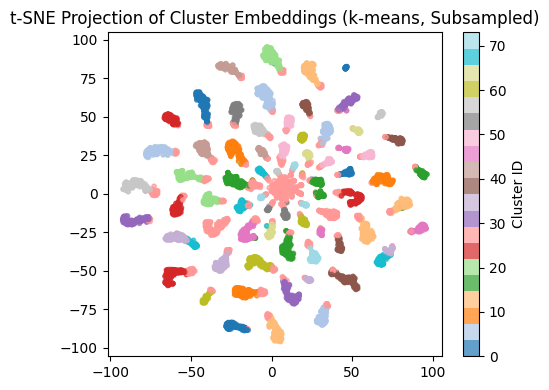

Saved: figures/t_SNE_Projection_of_Embeddings_Colored_by_True_Neuron_ID.pdf
Saved: figures/t_SNE_Projection_of_Embeddings_Colored_by_True_Neuron_ID.png


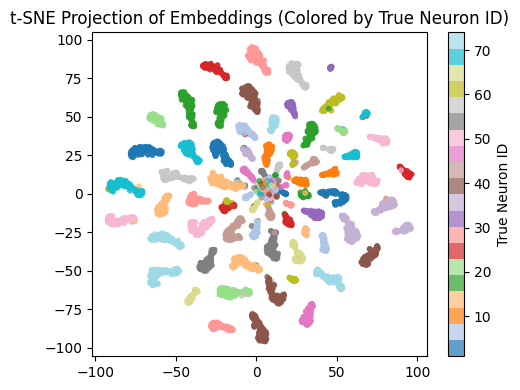

In [253]:
# # t-SNE visualization
# from sklearn.manifold import TSNE
# import time

# print("Computing t-SNE projection...")
# start_time = time.time()

# # Subsample if dataset is large (optional)
# n_samples = min(10000, len(all_embeddings))
# indices = np.random.choice(len(all_embeddings), n_samples, replace=False)

# # Run t-SNE
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# embeddings_tsne = tsne.fit_transform(all_embeddings[indices])

# print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")

# # Plot results
# plt.figure(figsize=(5, 4))
# scatter = plt.scatter(
#     embeddings_tsne[:, 0], 
#     embeddings_tsne[:, 1], 
#     c=cluster_ids[indices], 
#     cmap='tab20', 
#     s=10, 
#     alpha=0.7
# )
# plt.colorbar(scatter, label='Cluster ID')
# plt.title('t-SNE Projection of Cluster Embeddings (k-means, Subsampled)')
# plt.tight_layout()
# save_fig()
# plt.show()

# # Alternative: color by ground truth instead of cluster
# plt.figure(figsize=(5, 4))
# scatter = plt.scatter(
#     embeddings_tsne[:, 0], 
#     embeddings_tsne[:, 1], 
#     c=gt_labels_filtered[indices], 
#     cmap='tab20', 
#     s=10, 
#     alpha=0.7
# )
# plt.colorbar(scatter, label='True Neuron ID')
# plt.title('t-SNE Projection of Embeddings (Colored by True Neuron ID)')
# plt.tight_layout()
# save_fig()
# plt.show()

In [254]:
# t-SNE visualization with distinct colors for all 74 clusters
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import time

print("Computing t-SNE projection...")
start_time = time.time()

# Subsample if dataset is large (optional)
n_samples = min(10000, len(all_embeddings))
indices = np.random.choice(len(all_embeddings), n_samples, replace=False)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_tsne = tsne.fit_transform(all_embeddings[indices])

print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")




Computing t-SNE projection...
t-SNE completed in 86.70 seconds


Saved: figures/t_SNE_Projection_of_74_Clusters.pdf
Saved: figures/t_SNE_Projection_of_74_Clusters.png


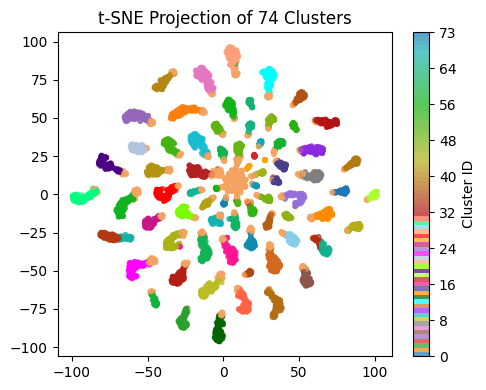

Saved: figures/t_SNE_Projection_Colored_by_True_Neuron_ID.pdf
Saved: figures/t_SNE_Projection_Colored_by_True_Neuron_ID.png


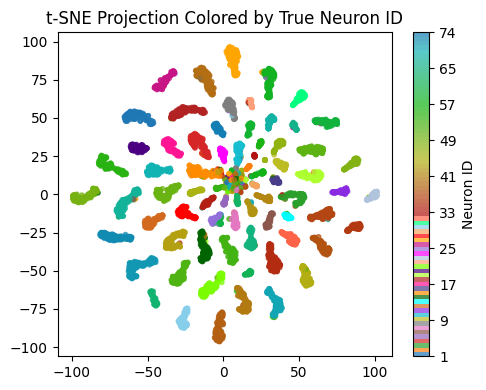

In [255]:
# Get unique cluster IDs for this sample
unique_sample_clusters = np.unique(cluster_ids[indices])
n_clusters = len(unique_sample_clusters)
colors = generate_distinct_colors(n_clusters)

# Create a mapping from cluster ID to color index
cluster_to_color = {cid: i for i, cid in enumerate(unique_sample_clusters)}

# Create a custom colormap
custom_cmap = mcolors.ListedColormap(colors[:n_clusters])

# Map cluster IDs to color indices (0 to n_clusters-1)
color_indices = np.array([cluster_to_color[cid] for cid in cluster_ids[indices]])

# Plot with proper discrete colormap
plt.figure(figsize=(5, 4))
scatter = plt.scatter(
    embeddings_tsne[:, 0], 
    embeddings_tsne[:, 1], 
    c=color_indices,
    cmap=custom_cmap,
    s=10, 
    alpha=0.7
)

# Create legend showing cluster IDs
# For many clusters, we can show a subset or create a separate legend
from matplotlib.lines import Line2D
if n_clusters <= 20:  # If few enough to show in legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
               label=f'Cluster {cid}', markersize=8)
        for i, cid in enumerate(unique_sample_clusters)
    ]
    plt.legend(handles=legend_elements, title="Clusters", 
               loc='center left', bbox_to_anchor=(1, 0.5),
               ncol=max(1, n_clusters//20))
else:
    # For many clusters, use a colorbar instead
    cbar = plt.colorbar(scatter, label='Cluster ID')
    # Customize colorbar ticks to show actual cluster IDs
    ticks = np.linspace(0, n_clusters-1, min(10, n_clusters))  # 10 ticks max
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([unique_sample_clusters[int(t)] for t in ticks])

plt.title(f't-SNE Projection of {n_clusters} Clusters')
plt.tight_layout()
save_fig()
plt.show()

# Similar visualization for ground truth neuron IDs
unique_neurons = np.unique(gt_labels_filtered[indices])
n_neurons = len(unique_neurons)
neuron_colors = generate_distinct_colors(n_neurons)
neuron_to_color = {nid: i for i, nid in enumerate(unique_neurons)}
neuron_color_indices = np.array([neuron_to_color[nid] for nid in gt_labels_filtered[indices]])
neuron_cmap = mcolors.ListedColormap(neuron_colors[:n_neurons])

plt.figure(figsize=(5, 4))
scatter = plt.scatter(
    embeddings_tsne[:, 0], 
    embeddings_tsne[:, 1], 
    c=neuron_color_indices,
    cmap=neuron_cmap,
    s=10, 
    alpha=0.7
)

# Use colorbar for many neurons
cbar = plt.colorbar(scatter, label='Neuron ID')
ticks = np.linspace(0, n_neurons-1, min(10, n_neurons))
cbar.set_ticks(ticks)
cbar.set_ticklabels([unique_neurons[int(t)] for t in ticks])

plt.title('t-SNE Projection Colored by True Neuron ID')
plt.tight_layout()
save_fig()
plt.show()

Saved: figures/t_SNE_of_Top_Clusters_Colored_by_Cluster.pdf
Saved: figures/t_SNE_of_Top_Clusters_Colored_by_Cluster.png


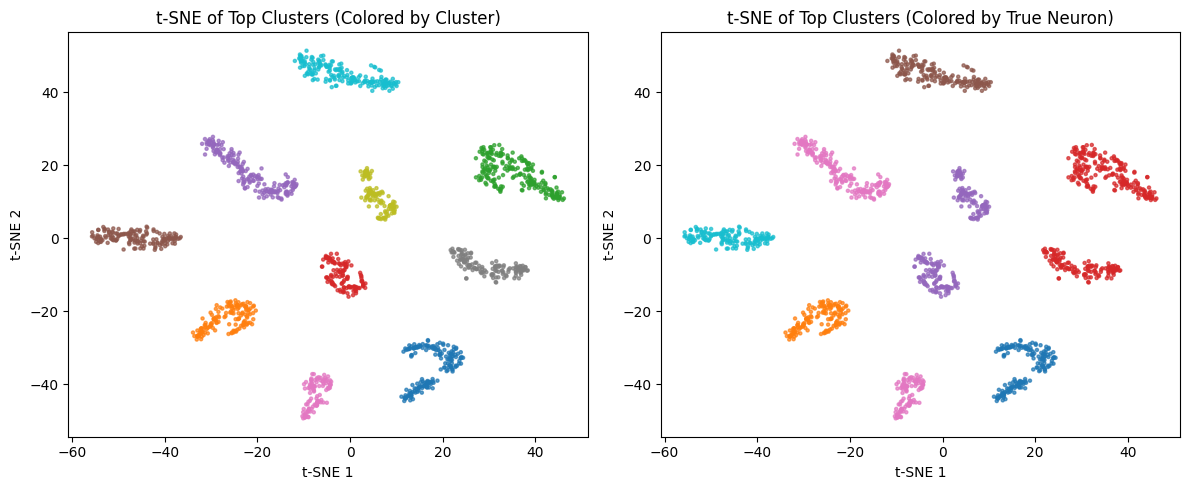

In [256]:
# t-SNE visualization of top clusters by purity
from sklearn.manifold import TSNE

# Select top 10 clusters by purity with at least 100 points
top_clusters = cluster_quality[cluster_quality['size'] > 100].sort_values('purity', ascending=False).head(10)['cluster_id'].values

# Create a mask for points in these clusters
mask = np.isin(cluster_ids, top_clusters)

# Subsample if needed
max_points_per_cluster = 1000
sampled_indices = []
for cluster in top_clusters:
    cluster_indices = np.where(cluster_ids == cluster)[0]
    if len(cluster_indices) > max_points_per_cluster:
        sampled_indices.extend(np.random.choice(cluster_indices, max_points_per_cluster, replace=False))
    else:
        sampled_indices.extend(cluster_indices)
sampled_indices = np.array(sampled_indices)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
emb_2d_tsne = tsne.fit_transform(all_embeddings[sampled_indices])

# Remap cluster IDs for the plot
plot_clusters = cluster_ids[sampled_indices]
plot_true_labels = gt_labels_filtered[sampled_indices]

# Create a mapping for colors
cluster_map = {c: i for i, c in enumerate(top_clusters)}
plot_cluster_colors = np.array([cluster_map[c] for c in plot_clusters])

# Plot t-SNE with both views
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot colored by cluster
scatter1 = ax1.scatter(emb_2d_tsne[:, 0], emb_2d_tsne[:, 1], 
                      c=plot_cluster_colors, cmap='tab10', s=5, alpha=0.7)
ax1.set_title('t-SNE of Top Clusters (Colored by Cluster)')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')

# Plot colored by true neuron
scatter2 = ax2.scatter(emb_2d_tsne[:, 0], emb_2d_tsne[:, 1], 
                      c=plot_true_labels, cmap='tab10', s=5, alpha=0.7)
ax2.set_title('t-SNE of Top Clusters (Colored by True Neuron)')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

plt.tight_layout()
save_fig()
plt.show()

In [257]:
# # UMAP; this takes a a few seconds to run, on truncated
# from umap.umap_ import UMAP
# # Subsample if dataset is very large
# # n_samples = min(10000, len(all_embeddings))
# # indices = np.random.choice(len(all_embeddings), n_samples, replace=False)

# # Run UMAP
# # Use the imported umap module to create the UMAP model
# umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
# embeddings_umap = umap_model.fit_transform(all_embeddings)

# plt.figure(figsize=(6, 5))
# scatter = plt.scatter(
#     embeddings_umap[:, 0], 
#     embeddings_umap[:, 1], 
#     c=cluster_ids, 
#     cmap='tab20', 
#     s=10, 
#     alpha=0.7
# )
# plt.colorbar(scatter, label='Cluster ID')
# plt.title('UMAP Projection of Cluster Embeddings (Complete set)')
# plt.tight_layout()
# plt.show()